# Package

In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

# Environment config

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load data

In [4]:
from preprocessing.load_dataset import raw_to_dict

In [5]:
# trainset, valset = raw_to_dict(data_mode = "small")
trainset, valset = raw_to_dict()

  0%|          | 0/117273 [00:00<?, ?it/s]


>> Loading msimut at /home/kientiet/Documents/My Project/python/ucla-cs168/data/msimut
>> Total running 75039

>> Loading msimut at /home/kientiet/Documents/My Project/python/ucla-cs168/data/mss


100%|██████████| 117273/117273 [00:00<00:00, 1016231.93it/s]


>> Total running 117273

>> Splitting the dataset


Total amount of train msimut/mss: 52 and 236


Total amount of train msimut/mss: 34 and 153

>> From dictionary to data instance


>> Sumary between two classes:
msimut 59142
mss 91755


>> Sumary between two classes:
msimut 36910
mss 62959

>> Done!


In [6]:
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 4)
valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size, num_workers = 4)
len(trainloader), len(valloader)

(590, 391)

torch.Size([64, 3, 224, 224]) torch.Size([64])


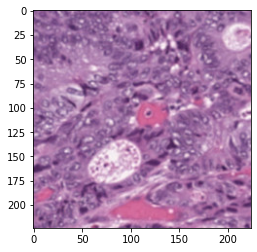

In [7]:
images, labels = next(iter(trainloader))

print(images.shape, labels.shape)
def imshow(img):
    inp = img.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    # plt.show()

imshow(images[0])

# SKNet-DualAttention model

In [8]:
from trainer.sknetdual_trainer import SKNetDualTrainer

In [9]:
sknetdual_trainer = SKNetDualTrainer(trainloader, valloader, num_cycle = 5)
max_epochs = sknetdual_trainer.get_max_epochs()

In [10]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", "sknetdual", "full")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = -1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/full'

In [11]:
tb_logger = loggers.TensorBoardLogger('logs/', name = "sknetdual")
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                     nb_sanity_val_steps=0, 
                     max_epochs = max_epochs, 
                     gpus = -1, 
                    logger = tb_logger
                    )

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [12]:
# from models.sknet import sknet18_32x4d

In [13]:
# model = sknet18_32x4d(2)
# model = model.to(device)
# torch.cuda.empty_cache()
# model(images.to(device))

# Learning rate finder

In [12]:
lr_finder = trainer.lr_find(sknetdual_trainer)

INFO:lightning:
    | Name                                                                    | Type                  | Params
--------------------------------------------------------------------------------------------------------------
0   | criterion                                                               | BCEWithLogitsLoss     | 0     
1   | model                                                                   | SKNetDual             | 32 M  
2   | model.sknet                                                             | Sequential            | 16 M  
3   | model.sknet.0                                                           | Sequential            | 9 K   
4   | model.sknet.0.0                                                         | Conv2d                | 9 K   
5   | model.sknet.0.1                                                         | BatchNorm2d           | 128   
6   | model.sknet.0.2                                                         | ReLU            

INFO:lightning:LR finder stopped early due to diverging loss.


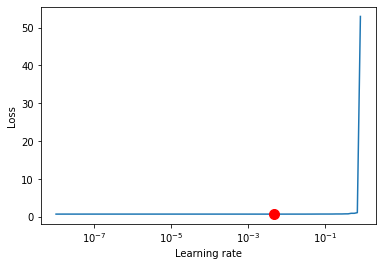

In [13]:
fig = lr_finder.plot(suggest = True)

In [14]:
sknetdual_trainer.base_lr = 8e-3
sknetdual_trainer.max_lr = 3e-4
sknetdual_trainer.configure_optimizers()

SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 1.1999999999999999e-05
    lr: 1.200000000000002e-05
    max_lr: 0.0003
    max_momentum: 0.95
    min_lr: 1.1999999999999998e-09
    momentum: 0.95
    nesterov: False
    weight_decay: 0.001
)

# Start to train the model

In [15]:
trainer.fit(sknetdual_trainer)

INFO:lightning:
    | Name                                                                    | Type                  | Params
--------------------------------------------------------------------------------------------------------------
0   | criterion                                                               | BCEWithLogitsLoss     | 0     
1   | model                                                                   | SKNetDual             | 32 M  
2   | model.sknet                                                             | Sequential            | 16 M  
3   | model.sknet.0                                                           | Sequential            | 9 K   
4   | model.sknet.0.0                                                         | Conv2d                | 9 K   
5   | model.sknet.0.1                                                         | BatchNorm2d           | 128   
6   | model.sknet.0.2                                                         | ReLU            

INFO:lightning:
Epoch 00001: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_1.ckpt


INFO:lightning:
Epoch 00002: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_2.ckpt


INFO:lightning:
Epoch 00003: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_3.ckpt


INFO:lightning:
Epoch 00004: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_4.ckpt


INFO:lightning:
Epoch 00005: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_5.ckpt


INFO:lightning:
Epoch 00006: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_6.ckpt


INFO:lightning:
Epoch 00007: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_7.ckpt


INFO:lightning:
Epoch 00008: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_8.ckpt


INFO:lightning:
Epoch 00009: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_9.ckpt


INFO:lightning:
Epoch 00010: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_10.ckpt


INFO:lightning:
Epoch 00011: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_11.ckpt


INFO:lightning:
Epoch 00012: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_12.ckpt


INFO:lightning:
Epoch 00013: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_13.ckpt


INFO:lightning:
Epoch 00014: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_14.ckpt


INFO:lightning:
Epoch 00015: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_15.ckpt


INFO:lightning:
Epoch 00016: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_16.ckpt


INFO:lightning:
Epoch 00017: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_17.ckpt


INFO:lightning:
Epoch 00018: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_18.ckpt


INFO:lightning:
Epoch 00019: saving model to /home/kientiet/Documents/My Project/python/ucla-cs168/checkpoint/sknetdual/_ckpt_epoch_19.ckpt


1

# Evaluate the model

## Evaluate on test set

In [9]:
from evaluate.evaluator import Evaluator
from trainer.sknetdual_trainer import SKNetDualTrainer

checkpoint_path = ["checkpoint/eval/sknetdual/full/_ckpt_epoch_{}.ckpt".format(x) for x in range(1, 20)]
evaluator = Evaluator(SKNetDualTrainer, "SKNet Dual", checkpoint_path, trainloader, valloader, valset, "logs/eval/sknetdual/version1/")

In [10]:
evaluator.run_validation()

>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_1.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [05:04<00:00,  1.28it/s]


{'accuracy_score/patient-level': 0.8181818181818182,
 'accuracy_score/picture-level': 0.6782785448938109,
 'auc_score/patient-level': 0.6845444059976932,
 'auc_score/picture-level': 0.6747720410769579,
 'f1_score/patient-level': 0.8994082840236687,
 'f1_score/picture-level': 0.7931900102986612,
 'precision_score/patient-level': 0.8216216216216217,
 'precision_score/picture-level': 0.6668217876429908,
 'recall_score/patient-level': 0.9934640522875817,
 'recall_score/picture-level': 0.9786527740275417}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_2.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [05:00<00:00,  1.30it/s]


{'accuracy_score/patient-level': 0.8342245989304813,
 'accuracy_score/picture-level': 0.7087584736004165,
 'auc_score/patient-level': 0.8031526336024606,
 'auc_score/picture-level': 0.7365991723297245,
 'f1_score/patient-level': 0.9063444108761329,
 'f1_score/picture-level': 0.8020552606506056,
 'precision_score/patient-level': 0.8426966292134831,
 'precision_score/picture-level': 0.7016706159726604,
 'recall_score/patient-level': 0.9803921568627451,
 'recall_score/picture-level': 0.9359583220826252}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_3.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:58<00:00,  1.31it/s]


{'accuracy_score/patient-level': 0.28342245989304815,
 'accuracy_score/picture-level': 0.5314161551632639,
 'auc_score/patient-level': 0.9086889657823914,
 'auc_score/picture-level': 0.8477592242871791,
 'f1_score/patient-level': 0.22093023255813954,
 'f1_score/picture-level': 0.4237603280343796,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9427460004383081,
 'recall_score/patient-level': 0.12418300653594772,
 'recall_score/picture-level': 0.27330484918756653}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_4.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:57<00:00,  1.31it/s]


{'accuracy_score/patient-level': 0.6898395721925134,
 'accuracy_score/picture-level': 0.6165877299262034,
 'auc_score/patient-level': 0.6766628219915418,
 'auc_score/picture-level': 0.6506409199599991,
 'f1_score/patient-level': 0.7883211678832117,
 'f1_score/picture-level': 0.6884707069227828,
 'precision_score/patient-level': 0.8925619834710744,
 'precision_score/picture-level': 0.7057243886980018,
 'recall_score/patient-level': 0.7058823529411765,
 'recall_score/picture-level': 0.6720405343159834}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_5.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:57<00:00,  1.31it/s]


{'accuracy_score/patient-level': 0.20855614973262032,
 'accuracy_score/picture-level': 0.4366019485526039,
 'auc_score/patient-level': 0.817762399077278,
 'auc_score/picture-level': 0.7466780168017471,
 'f1_score/patient-level': 0.06329113924050632,
 'f1_score/picture-level': 0.2042484584488318,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9318621757646148,
 'recall_score/patient-level': 0.032679738562091505,
 'recall_score/picture-level': 0.11469368954398894}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_6.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [05:22<00:00,  1.21it/s]


{'accuracy_score/patient-level': 0.8181818181818182,
 'accuracy_score/picture-level': 0.6636293544543351,
 'auc_score/patient-level': 0.9621299500192234,
 'auc_score/picture-level': 0.8353460386326772,
 'f1_score/patient-level': 0.9,
 'f1_score/picture-level': 0.789021824462239,
 'precision_score/patient-level': 0.8181818181818182,
 'precision_score/picture-level': 0.6525252944964993,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9977286805698947}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_7.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [05:13<00:00,  1.25it/s]


{'accuracy_score/patient-level': 0.9893048128342246,
 'accuracy_score/picture-level': 0.9223382631246934,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9737687659434102,
 'f1_score/patient-level': 0.9935064935064934,
 'f1_score/picture-level': 0.9395196506550219,
 'precision_score/patient-level': 0.9870967741935484,
 'precision_score/picture-level': 0.922810618709885,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9568449308279992}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_8.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [05:03<00:00,  1.29it/s]


{'accuracy_score/patient-level': 0.31016042780748665,
 'accuracy_score/picture-level': 0.45088065365628976,
 'auc_score/patient-level': 0.7031910803537101,
 'auc_score/picture-level': 0.6637262507138634,
 'f1_score/patient-level': 0.2950819672131148,
 'f1_score/picture-level': 0.28386742928778497,
 'precision_score/patient-level': 0.9,
 'precision_score/picture-level': 0.79807621704971,
 'recall_score/patient-level': 0.17647058823529413,
 'recall_score/picture-level': 0.17263616004066137}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_9.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:57<00:00,  1.32it/s]


{'accuracy_score/patient-level': 0.8716577540106952,
 'accuracy_score/picture-level': 0.7548688782304819,
 'auc_score/patient-level': 0.8936947327950788,
 'auc_score/picture-level': 0.8035668088776831,
 'f1_score/patient-level': 0.9268292682926829,
 'f1_score/picture-level': 0.8229824218891227,
 'precision_score/patient-level': 0.8685714285714285,
 'precision_score/picture-level': 0.7553691364251772,
 'recall_score/patient-level': 0.9934640522875817,
 'recall_score/picture-level': 0.9038898330659636}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_10.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:57<00:00,  1.31it/s]


{'accuracy_score/patient-level': 0.9893048128342246,
 'accuracy_score/picture-level': 0.9089006598644224,
 'auc_score/patient-level': 0.9996155324875048,
 'auc_score/picture-level': 0.9730913289033999,
 'f1_score/patient-level': 0.9935064935064934,
 'f1_score/picture-level': 0.9306998567990007,
 'precision_score/patient-level': 0.9870967741935484,
 'precision_score/picture-level': 0.8941529454811562,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9703616639400244}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_11.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:57<00:00,  1.31it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.9703411469024422,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9951931133173848,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.9766418522490695,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.969835079641028,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9835448466462301}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_12.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:57<00:00,  1.31it/s]


{'accuracy_score/patient-level': 0.983957219251337,
 'accuracy_score/picture-level': 0.8951526499714626,
 'auc_score/patient-level': 0.9996155324875048,
 'auc_score/picture-level': 0.9588423015844679,
 'f1_score/patient-level': 0.990228013029316,
 'f1_score/picture-level': 0.9191809263590124,
 'precision_score/patient-level': 0.987012987012987,
 'precision_score/picture-level': 0.8940422209543257,
 'recall_score/patient-level': 0.9934640522875817,
 'recall_score/picture-level': 0.945774234025318}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_13.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [05:04<00:00,  1.28it/s]


{'accuracy_score/patient-level': 0.8823529411764706,
 'accuracy_score/picture-level': 0.8025913947270925,
 'auc_score/patient-level': 0.9978854286812764,
 'auc_score/picture-level': 0.9349686200936961,
 'f1_score/patient-level': 0.9225352112676055,
 'f1_score/picture-level': 0.8216885994663773,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9541864470865017,
 'recall_score/patient-level': 0.8562091503267973,
 'recall_score/picture-level': 0.7215012944932416}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_14.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [05:05<00:00,  1.28it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.9344240955651903,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.985423940431377,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.9495022708171086,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9226734602127978,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9779380231579282}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_15.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:57<00:00,  1.31it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.9925101883467342,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9995549790977704,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.9940716787927781,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9920588467926916,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9960926952461125}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_16.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:57<00:00,  1.31it/s]


{'accuracy_score/patient-level': 0.8449197860962567,
 'accuracy_score/picture-level': 0.763149726141245,
 'auc_score/patient-level': 0.9131103421760862,
 'auc_score/picture-level': 0.8533770714505023,
 'f1_score/patient-level': 0.8989547038327527,
 'f1_score/picture-level': 0.8012736498975032,
 'precision_score/patient-level': 0.9626865671641791,
 'precision_score/picture-level': 0.8505056269953094,
 'recall_score/patient-level': 0.8431372549019608,
 'recall_score/picture-level': 0.7574294382058164}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_17.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:59<00:00,  1.31it/s]


{'accuracy_score/patient-level': 0.8556149732620321,
 'accuracy_score/picture-level': 0.8092200783025764,
 'auc_score/patient-level': 0.9961553248750481,
 'auc_score/picture-level': 0.9499148444019481,
 'f1_score/patient-level': 0.9032258064516129,
 'f1_score/picture-level': 0.8269592305666306,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9656189021803682,
 'recall_score/patient-level': 0.8235294117647058,
 'recall_score/picture-level': 0.7231213964643657}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_18.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:57<00:00,  1.31it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.9454385244670518,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9958161712832867,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.9583705774945948,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9232784761680455,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9962356454200353}
>> Evaluate checkpoint/eval/sknetdual/full/_ckpt_epoch_19.ckpt


  0%|          | 0/391 [00:00<?, ?it/s]

>> running the evaluation on picture-level and patient-level


100%|██████████| 391/391 [04:57<00:00,  1.31it/s]


{'accuracy_score/patient-level': 1.0,
 'accuracy_score/picture-level': 0.9983177963131703,
 'auc_score/patient-level': 1.0,
 'auc_score/picture-level': 0.9998704596617731,
 'f1_score/patient-level': 1.0,
 'f1_score/picture-level': 0.9986656288224174,
 'precision_score/patient-level': 1.0,
 'precision_score/picture-level': 0.9987925583464404,
 'recall_score/patient-level': 1.0,
 'recall_score/picture-level': 0.9985387315554567}


## Evaluate on noise set

In [14]:
evaluator.run_test_set()

  0%|          | 0/43 [00:00<?, ?it/s]



>> Evaluate speckle noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/speckle
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

>> Loading table from /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/table/speckle.csv


>> Evaluate pepper noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/pepper
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

>> Loading table from /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/table/pepper.csv


>> Evaluate salt noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/salt
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

>> Loading table from /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/table/salt.csv


>> Evaluate poisson noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/poisson
Transform to dataset and loader
Start evaluating...


  0%|          | 0/43 [00:00<?, ?it/s]

>> Loading table from /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/table/poisson.csv


>> Evaluate gaussian noise
Extracting the test images in /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/data/gaussian
Transform to dataset and loader
Start evaluating...


100%|██████████| 43/43 [00:18<00:00,  2.34it/s]

>> Loading table from /home/kientiet/Documents/My Project/python/ucla-cs168/evaluate/table/gaussian.csv


## Draw calibrated graph